.ipynb folder for testing model collapse on two general machine learning models: random forest & linear regression. 

To start, there will be several tests of the machine learning models to try and maximize accuracy before the 

Setup: import libraries, create dataset, etc. 

In [25]:
                 

# using alexhusted's random forest project as reference for implementing random forest

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import SkLearn
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from collections import Counter

# number of generations to run model collapse for
N_GENERATIONS = 100

                

In [26]:
# dataset with pandas
url = "https://archive.ics.uci.edu/static/public/186/data.csv"
wine_data = pd.read_csv(url, sep=',')

In [27]:
# change red -> 0, white -> 1 so they're useable in the model
color = {'red': 0,'white': 1} 
wine_data.color = [color[item] for item in wine_data.color] 
#print(wine_data.describe())
print()
print(wine_data.dtypes)


fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                     int64
dtype: object


Correlation Matrix: I'm using a correlation matrix to examine which categories in the dataset have too strong of a correlation with other categories so that they can be removed to prevent overfitting. 

<Axes: >

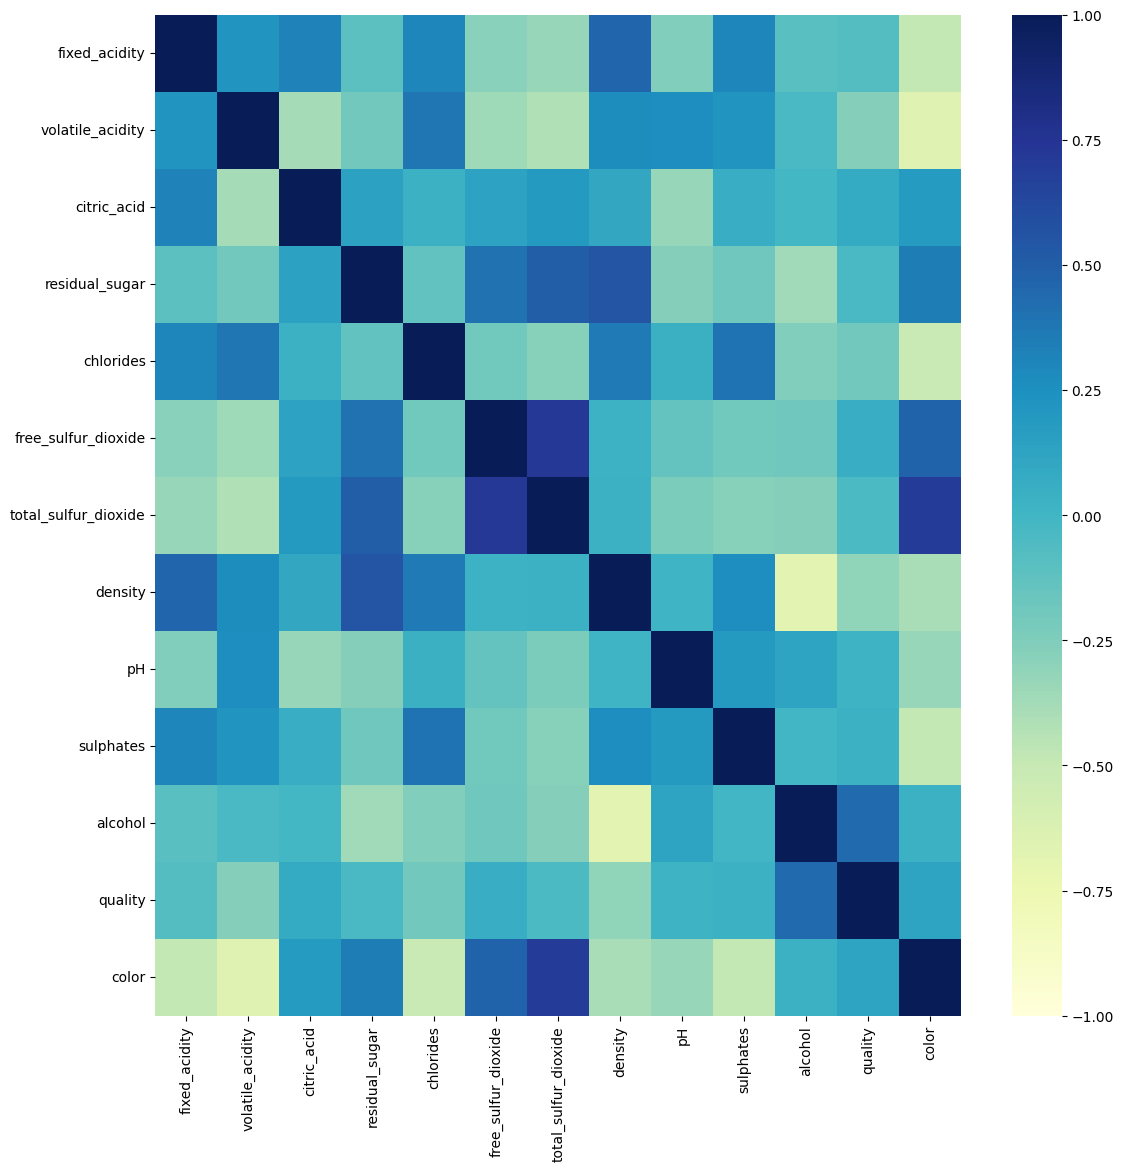

In [28]:
corr_matrix = wine_data.corr()
#print(corr_matrix)
# Plot the new correlation matrix based upon the created dataframe 'corr_df'
plt.figure(figsize=(13,13))
sns.heatmap(corr_matrix, cmap='YlGnBu', vmin=-1, vmax=1)

In [29]:
# print out the exact numbers of the correlation matrix
print(corr_matrix)

                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000          0.219008     0.324436   
volatile_acidity           0.219008          1.000000    -0.377981   
citric_acid                0.324436         -0.377981     1.000000   
residual_sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free_sulfur_dioxide       -0.282735         -0.352557     0.133126   
total_sulfur_dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   
quality                   -0.076743         -0.265699     0.085532   
color                     -0.486740         -0.653036     0.187397   

                   

In [30]:
# Remove the "total_sulfur_dioxide" category because of high correlations (|corr| > 0.7) with "free_sulfur_dioxide" and "sulphates"
wine_data_init = wine_data
wine_data = wine_data.drop('total_sulfur_dioxide', axis=1)

Random Forest Model

In [31]:
# create datasets with and without 'quality'
Xa1 = wine_data.drop(['quality'], axis=1)
ya1 = wine_data['quality']

In [61]:
# train/test split on the data
Xa1_train, Xa1_test, ya1_train, ya1_test = train_test_split(Xa1, ya1, test_size=0.7, random_state=42)

# normalize the sizes of the dataframes
Xa1_test = Xa1_test.tail(-1)
ya1_test = ya1_test.tail(-1)

#confirm the data
print(Xa1_test)
print(ya1_test)
print(Xa1_train)
print(ya1_train)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1419            7.7             0.640         0.21             2.2      0.077   
4761            6.8             0.390         0.34             7.4      0.020   
4690            6.3             0.280         0.47            11.2      0.040   
4032            7.4             0.350         0.20            13.9      0.054   
1297            7.2             0.530         0.14             2.1      0.064   
...             ...               ...          ...             ...        ...   
2289            6.9             0.200         0.34             1.9      0.043   
2740            9.3             0.340         0.49             7.3      0.052   
275             7.9             0.545         0.06             4.0      0.087   
1035           10.1             0.370         0.34             2.4      0.085   
1229            7.6             0.430         0.29             2.1      0.075   

      free_sulfur_dioxide  

In [62]:
# initialize rf model (sklearn)
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(Xa1_train, ya1_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Examining Results

In [36]:
class SelfSynthesizer:
    """
    Based on Caiola and Reiter (2010): "Random Forests for Generating Partially Synthetic, Categorical Data".
    Extracts leaf node data from each tree in the random forest:
    - uses them to form multinomial distributions for generating synthetic data
    """

    def __init__(self, rf_model: RandomForestClassifier):
        """
        Initializes the SelfSynthesizer with a trained RandomForestClassifier.
        :param rf_model: A trained RandomForestClassifier model.
        """
        # the base model
        self.model = rf_model
        # number of decision trees in the model
        self.n_trees = rf_model.n_estimators
        # minimum number of samples per leaf in the trees
        self.min_samples_leaf  = rf_model.min_samples_leaf
        # the model's random state
        self.random_state = rf_model.random_state
        # number of features in the model
        self.n_features = rf_model.n_features_in_
        # number of classes in the model
        self.n_classes = rf_model.n_classes_

    def dataframe_to_arrays(self, df: pd.DataFrame) -> tuple[np.ndarray, list[str]]:
        """
        Convert pandas DataFrame to numpy ndarray

        :param df: pandas DataFrame
        :return: tuple of ndarray and feature names
        """
        feature_names = df.columns.tolist()
        X = df.values
        return X, feature_names

    def arrays_to_dataframe(self, X: np.ndarray, y: np.ndarray, feature_names: list[str], target_name: str) -> pd.DataFrame:
        """
        Convert numpy arrays to pandas DataFrame
        :param X: feature ndarray
        :param y: target ndarray
        :param feature_names: list of feature names
        :param target_name: name of the target column
        :return: pandas DataFrame containing the features and target
        """
        import pandas as pd
        df = pd.DataFrame(X, columns=feature_names)
        df[target_name] = y
        return df

    def _extract_leaf_predictions(self, X: np.ndarray) -> np.ndarray:
        """
        For each sample in X, get predictions from all trees to form multinomial distributions
        :param X: Input features as ndarray
        :return: A 2D numpy array where each row corresponds to a sample and each column to a tree's leaf prediction.
        """
        n_samples = X.shape[0]
        predictions = np.zeros((n_samples, self.n_trees), dtype=int)
        for i, tree in enumerate(self.model.estimators_):
            leaf_ids = tree.apply(X)
            for j in range(n_samples):
                leaf_id = leaf_ids[j]
                leaf_values = tree.tree_.value[leaf_id][0]
                if np.sum(leaf_values) > 0:
                    probabilities = leaf_values / np.sum(leaf_values)
                    predictions[j, i] = np.random.choice(self.n_classes, p=probabilities)
                else:
                    predictions[j, i] = np.random.choice(self.n_classes)
        return predictions

    def synthesize_data(self, X: np.ndarray) -> np.ndarray:
        """
        Generate synthetic labels using the random forest model.
        
        :param X: feature ndarray to generate labels for
        :return: A numpy array of synthetic labels generated from the random forest model.
        """
        n_samples = X.shape[0]
        tree_predictions = self._extract_leaf_predictions(X)
        y_synthetic = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            prediction_counts = np.bincount(tree_predictions[i], minlength=self.n_classes)
            prediction_probabilities = prediction_counts / self.n_trees
            y_synthetic[i] = np.random.choice(self.n_classes, p=prediction_probabilities)
        return y_synthetic

    def generate_synthetic_features(self, n_samples: int, X_previous: np.ndarray) -> np.ndarray:
        """
        Generate synthetic features by sampling from the training distribution.
        
        :param n_samples: number of synthetic samples to generate
        :param X_previous: previous generation's features as ndarray
        :return: ndarray of synthetic features.
        """
        # ensure each tree only generates a proportional number of samples, and not more
        n_trees = len(self.model.estimators_)
        samples_per_tree = n_samples // n_trees
        remainder = n_samples % n_trees
        synthetic_features = []

        for i, tree in enumerate(self.model.estimators_):
            # Get the leaf IDs for each sample in the previous generation
            leaf_ids = tree.apply(X_previous)
            unique_leaves = np.unique(leaf_ids)
            leaf_samples = {}

            for leaf_id in unique_leaves:
                mask = leaf_ids == leaf_id
                leaf_samples[leaf_id] = X_previous[mask]
            n_generate = samples_per_tree + (1 if i < remainder else 0)

            synthetic_tree_features = []
            for _ in range(n_generate):
                weights = np.array([len(samples) for samples in leaf_samples.values()])
                weights = weights / np.sum(weights) if np.sum(weights) > 0 else np.ones_like(weights)/len(weights)
                chosen_leaf = np.random.choice(list(leaf_samples.keys()), p=weights)
                leaf_data = leaf_samples[chosen_leaf]

                if len(leaf_data) > 0:
                    idx = np.random.choice(len(leaf_data))
                    base_sample = leaf_data[idx].copy()
                    synthetic_tree_features.append(base_sample)
            if synthetic_tree_features:
                synthetic_features.append(np.array(synthetic_tree_features))
        if synthetic_features:
            X_synthetic = np.vstack(synthetic_features)
        else:
            X_synthetic = np.empty((0, X_previous.shape[1]))
        return X_synthetic

    def _update_metrics(self, metrics: dict, generation: int, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
        """
        update metrics for tracking model collapse
        """
        metrics["generation"].append(generation)
        train_acc = self.model.score(X_train, y_train)
        test_acc = self.model.score(X_test, y_test)
        metrics["train_accuracy"].append(train_acc)
        metrics["original_accuracy"].append(test_acc)
        class_counts = np.bincount(y_train)
        class_probs = class_counts / len(y_train)
        entropy = -np.sum(class_probs * np.log2(class_probs + 1e-10))
        metrics["class_distribution_entropy"].append(entropy)
        metrics["feature_variance"].append(np.var(X_train, axis=0).mean())
        if X_train.shape[1] > 1:
            corr_matrix = np.corrcoef(X_train.T)
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
            avg_corr = np.mean(np.abs(corr_matrix[mask]))
            metrics["feature_correlation"].append(avg_corr)
        else:
            metrics["feature_correlation"].append(0)
        leaf_diversities = []
        for tree in self.model.estimators_:
            leaf_ids = tree.apply(X_train)
            unique_leaves = len(np.unique(leaf_ids))
            max_leaves = tree.tree_.node_count // 2 # approximation
            diversity = unique_leaves / max(max_leaves, 1)
            leaf_diversities.append(diversity)
        metrics["leaf_diversity"].append(np.mean(leaf_diversities))
        cm = confusion_matrix(y_true=y_test, y_pred=self.model.predict(X_test))
        metrics["confusion_matrix"].append(cm)

    def simulate_collapse(self, X_original: np.ndarray, y_original: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, n_generations=20) -> tuple[list, list, dict]:
        """
        Simulate the collapse of the model over multiple generations.
        :param X_original: original features as ndarray
        :param y_original: original target as ndarray
        :param n_generations: number of generations to simulate
        Returns:
            models: list of models from each generation
            metrics: dictionary of tracked metrics
        """
        models = []
        synthetic_data = []
        metrics = {
            "generation": [],
            "train_accuracy": [],
            "original_accuracy": [],
            "class_distribution_entropy": [],
            "true_match_rate": [],
            "feature_variance": [],
            "feature_correlation": [],
            "leaf_diversity": [],
            "confusion_matrix": []
        }
        print("Generation 0 (Original)")
        self.model.fit(X_original, y_original)
        models.append(self.model)
        self._update_metrics(metrics, 0, X_original, y_original, X_test, y_test)
        X_current = X_original.copy()
        y_current = y_original.copy()
        for gen in range(1, n_generations + 1):
            print(f"***Generation {gen}/{n_generations}***")
            X_synthetic = self.generate_synthetic_features(len(X_current), X_current)
            print(f"generated {X_synthetic.shape[0]} synthetic samples")
            y_synthetic = self.model.predict(X_synthetic)
            print(f"generated {len(y_synthetic)} synthetic labels")
            synthetic_data.append((X_synthetic, y_synthetic))
            new_rf = RandomForestClassifier(n_estimators=self.n_trees, min_samples_leaf=self.min_samples_leaf, random_state=self.random_state)
            new_rf.fit(X_synthetic, y_synthetic)
            new_synthesizer = SelfSynthesizer(new_rf)
            models.append(new_synthesizer.model)
            print(f"Trained new model")
            self = new_synthesizer
            X_current = X_synthetic
            y_current = y_synthetic
            self._update_metrics(metrics, gen, X_synthetic, y_synthetic, X_test, y_test)
            print(f"updated metrics")
        return models, synthetic_data, metrics

    def simulate_collapse_df(self, X_original_df: pd.DataFrame, y_original: pd.Series, X_test_df: pd.DataFrame, y_test: pd.Series, n_generations: int) -> tuple[list, list, dict]:
        """
        Simulate collapse with dataframe i/o. Run generations on self-synthesized features
        :param X_original_df: pandas DataFrame of features
        :param y_original: pandas Series of target
        :param n_generations: number of generations of model collapse to run
        :return: 
        """
        X_original, feature_names = self.dataframe_to_arrays(X_original_df)
        X_test, _ = self.dataframe_to_arrays(X_test_df)
        models, synthetic_data, metrics = self.simulate_collapse(X_original, y_original, X_test, y_test, n_generations)
        return models, synthetic_data, metrics


In [63]:

# Ensure all inputs are DataFrames/Series
synthesizer = SelfSynthesizer(rf_model)
models, synthetic_data, metrics = synthesizer.simulate_collapse_df(
    Xa1_train, ya1_train, Xa1_test, ya1_test, n_generations=N_GENERATIONS
)

Generation 0 (Original)
***Generation 1/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 2/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 3/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 4/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 5/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 6/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 7/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 8/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics


In [38]:
# print results function
def print_results(metrics: dict):
    print("\nModel Collapse Simulation Results")
    print("=" * 100)
    print(f"{'Gen':>4} | {'Train Acc':>9} | {'Test Acc':>8} | {'Class Ent':>9} | "
            f"{'Feat Var':>9} | {'Feat Corr':>9} | {'Leaf Div':>8}")
    print("-" * 100)

    for i in range(len(metrics['generation'])):
        print(f"{metrics['generation'][i]:4d} | "
                f"{metrics['train_accuracy'][i]:9.4f} | "
                f"{metrics['original_accuracy'][i]:8.4f} | "
                f"{metrics['class_distribution_entropy'][i]:9.4f} | "
                f"{metrics['feature_variance'][i]:9.4f} | "
                f"{metrics['feature_correlation'][i]:9.4f} | "
                f"{metrics['leaf_diversity'][i]:8.4f}")

    # Visualize collapse
    if len(metrics['generation']) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Test accuracy
        axes[0, 0].plot(metrics['generation'], metrics['original_accuracy'], 'b-o', linewidth=2)
        axes[0, 0].set_xlabel('Generation')
        axes[0, 0].set_ylabel('Test Accuracy')
        axes[0, 0].set_title('Model Performance Degradation')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Class entropy
        axes[0, 1].plot(metrics['generation'], metrics['class_distribution_entropy'], 'r-o', linewidth=2)
        axes[0, 1].set_xlabel('Generation')
        axes[0, 1].set_ylabel('Class Entropy')
        axes[0, 1].set_title('Loss of Output Diversity')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Feature variance
        axes[0, 2].plot(metrics['generation'], metrics['feature_variance'], 'g-o', linewidth=2)
        axes[0, 2].set_xlabel('Generation')
        axes[0, 2].set_ylabel('Feature Variance')
        axes[0, 2].set_title('Feature Diversity Loss')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Feature correlation
        axes[1, 0].plot(metrics['generation'], metrics['feature_correlation'], 'm-o', linewidth=2)
        axes[1, 0].set_xlabel('Generation')
        axes[1, 0].set_ylabel('Avg Feature Correlation')
        axes[1, 0].set_title('Feature Correlation Increase')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Leaf diversity
        axes[1, 1].plot(metrics['generation'], metrics['leaf_diversity'], 'c-o', linewidth=2)
        axes[1, 1].set_xlabel('Generation')
        axes[1, 1].set_ylabel('Leaf Diversity')
        axes[1, 1].set_title('Tree Structure Simplification')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Train vs test accuracy
        axes[1, 2].plot(metrics['generation'], metrics['train_accuracy'], 'g-o', label='Train', linewidth=2)
        axes[1, 2].plot(metrics['generation'], metrics['original_accuracy'], 'r-o', label='Test', linewidth=2)
        axes[1, 2].set_xlabel('Generation')
        axes[1, 2].set_ylabel('Accuracy')
        axes[1, 2].set_title('Train vs Test Performance')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.suptitle('Random Forest Model Collapse Simulation\n'
                        '(Label Synthesis: Caiola & Reiter 2010, Feature Synthesis: Ishwaran & Malley 2014)', 
                        fontsize=14)
        plt.tight_layout()
        plt.show()


Model Collapse Simulation Results
 Gen | Train Acc | Test Acc | Class Ent |  Feat Var | Feat Corr | Leaf Div
----------------------------------------------------------------------------------------------------
   0 |    1.0000 |   0.5901 |    1.8235 |   28.4183 |    0.2500 |   1.0021
   1 |    1.0000 |   0.5725 |    1.8287 |   29.2469 |    0.2471 |   1.0027
   2 |    1.0000 |   0.5623 |    1.8051 |   27.2180 |    0.2454 |   1.0033
   3 |    1.0000 |   0.5382 |    1.7814 |   26.0826 |    0.2410 |   1.0040
   4 |    1.0000 |   0.5412 |    1.7932 |   25.6894 |    0.2427 |   1.0046
   5 |    1.0000 |   0.5322 |    1.8083 |   25.4911 |    0.2434 |   1.0053
   6 |    1.0000 |   0.5278 |    1.7950 |   25.8369 |    0.2432 |   1.0060
   7 |    1.0000 |   0.5184 |    1.7858 |   25.5639 |    0.2405 |   1.0066
   8 |    1.0000 |   0.5197 |    1.7970 |   26.2959 |    0.2439 |   1.0074
   9 |    1.0000 |   0.5124 |    1.7610 |   25.9649 |    0.2389 |   1.0083
  10 |    1.0000 |   0.5069 |    1.7549

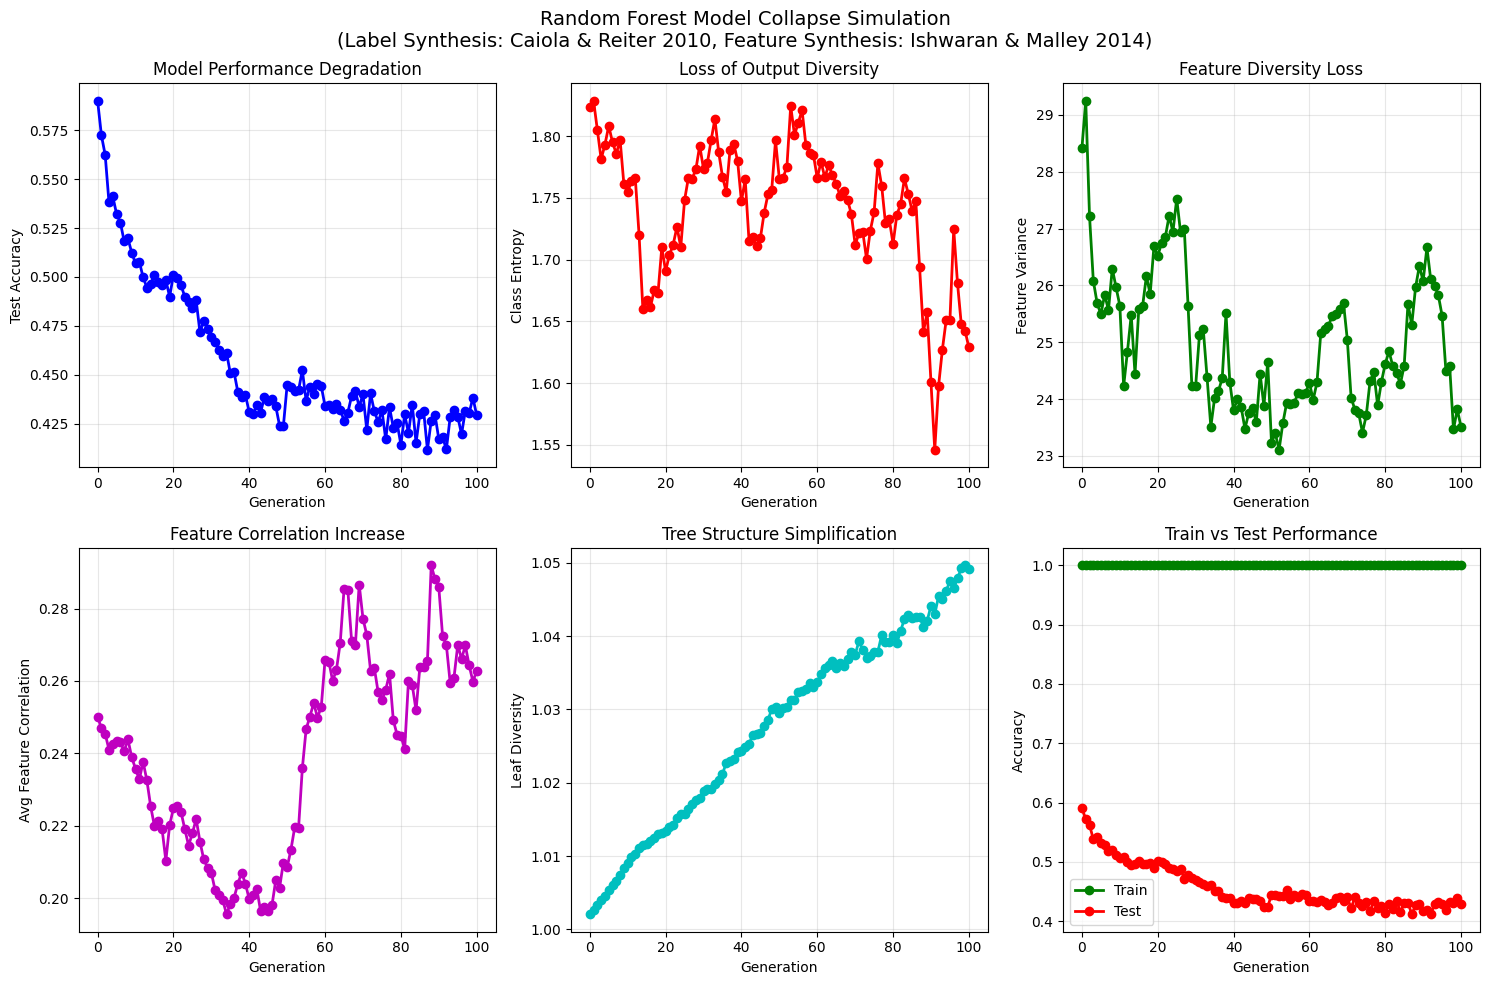

In [64]:
print_results(metrics)

In [40]:
# confusion matrix display - text
def confusion_matrix_text(metrics: dict):
    for i, cm in enumerate(metrics["confusion_matrix"]):
        print(f"Confusion matrix {i}:")
        print(cm)

# confusion matrix display - visual
def confusion_matrix_visual(metrics: dict):
    # visual display
    for i, cm in enumerate(metrics["confusion_matrix"]):
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig,ax = plt.subplots(figsize=(4,4))
        ax.matshow(cmn, cmap=plt.cm.Greys, alpha=0.7)
        for k in range(cmn.shape[0]):
            for j in range(cmn.shape[1]):
                ax.text(x=j, y=k, s=f'{cmn[k,j]:.3f}', va='center', ha='center')
        plt.title(f'Confusion Matrix Generation {i}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

In [41]:
confusion_matrix_text(metrics)

Confusion matrix 0:
[[   0    0   11   11    0    0    0]
 [   1    5   93   51    1    0    0]
 [   0    3 1012  445   13    0    0]
 [   0    3  474 1405  104    5    0]
 [   0    0   34  457  273    7    0]
 [   0    0    4   70   39   22    0]
 [   0    0    0    3    1    0    0]]
Confusion matrix 1:
[[   0    0    9   12    1    0    0]
 [   1    3   98   44    5    0    0]
 [   0    6  959  498   10    0    0]
 [   0    3  520 1329  133    6    0]
 [   0    1   48  487  226    9    0]
 [   0    0    0   82   34   19    0]
 [   0    0    0    3    1    0    0]]
Confusion matrix 2:
[[   0    0   12   10    0    0    0]
 [   1    2   95   48    4    1    0]
 [   2    5  941  510   15    0    0]
 [   0    2  522 1301  163    3    0]
 [   0    0   46  481  238    6    0]
 [   0    0    1   62   52   20    0]
 [   0    0    1    1    2    0    0]]
Confusion matrix 3:
[[   0    0   11   10    1    0    0]
 [   0    6   93   46    6    0    0]
 [   2    3  915  532   19    2    0]
 [   

In [ ]:
confusion_matrix_visual(metrics)

Run the generations

Using 'color' as the target variable instead

In [42]:
# create datasets with and without 'color', with 'quality' added back
wine_data_init = wine_data_init.drop('free_sulfur_dioxide', axis=1)
Xb1 = wine_data_init.drop('color', axis=1)
yb1 = wine_data_init['color']

In [65]:
# train/test split on the data
Xb1_train, Xb1_test, yb1_train, yb1_test = train_test_split(Xb1, yb1, test_size=0.7, random_state=42)
# normalize the sizes of the dataframes
Xb1_test = Xb1_test.tail(-1)
yb1_test = yb1_test.tail(-1)

#confirm the data
print(Xb1_test)
print(yb1_test)
print(Xb1_train)
print(yb1_train)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
1419            7.7             0.640         0.21             2.2      0.077   
4761            6.8             0.390         0.34             7.4      0.020   
4690            6.3             0.280         0.47            11.2      0.040   
4032            7.4             0.350         0.20            13.9      0.054   
1297            7.2             0.530         0.14             2.1      0.064   
...             ...               ...          ...             ...        ...   
2289            6.9             0.200         0.34             1.9      0.043   
2740            9.3             0.340         0.49             7.3      0.052   
275             7.9             0.545         0.06             4.0      0.087   
1035           10.1             0.370         0.34             2.4      0.085   
1229            7.6             0.430         0.29             2.1      0.075   

      total_sulfur_dioxide 

In [66]:
# initialize rf model (sklearn)
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(Xb1_train, yb1_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [67]:

# Ensure all inputs are DataFrames/Series
synthesizer = SelfSynthesizer(rf_model)
models, synthetic_data, metrics = synthesizer.simulate_collapse_df(
    Xb1_train, yb1_train, Xb1_test, yb1_test, n_generations=N_GENERATIONS
)

Generation 0 (Original)
***Generation 1/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 2/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 3/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 4/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 5/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 6/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 7/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics
***Generation 8/100***
generated 1949 synthetic samples
generated 1949 synthetic labels
Trained new model
updated metrics



Model Collapse Simulation Results
 Gen | Train Acc | Test Acc | Class Ent |  Feat Var | Feat Corr | Leaf Div
----------------------------------------------------------------------------------------------------
   0 |    0.9995 |   0.9938 |    0.7884 |  276.9611 |    0.2170 |   1.0261
   1 |    1.0000 |   0.9916 |    0.8012 |  285.6284 |    0.2212 |   1.0312
   2 |    1.0000 |   0.9897 |    0.8199 |  290.3551 |    0.2196 |   1.0373
   3 |    1.0000 |   0.9912 |    0.8159 |  288.9447 |    0.2180 |   1.0407
   4 |    1.0000 |   0.9905 |    0.8151 |  300.0808 |    0.2196 |   1.0503
   5 |    1.0000 |   0.9901 |    0.8151 |  302.0069 |    0.2108 |   1.0585
   6 |    1.0000 |   0.9892 |    0.8413 |  297.8636 |    0.2107 |   1.0621
   7 |    1.0000 |   0.9886 |    0.8556 |  289.8406 |    0.2147 |   1.0648
   8 |    1.0000 |   0.9875 |    0.8738 |  297.2249 |    0.2306 |   1.0680
   9 |    1.0000 |   0.9826 |    0.8666 |  285.7196 |    0.2391 |   1.0743
  10 |    1.0000 |   0.9826 |    0.8802

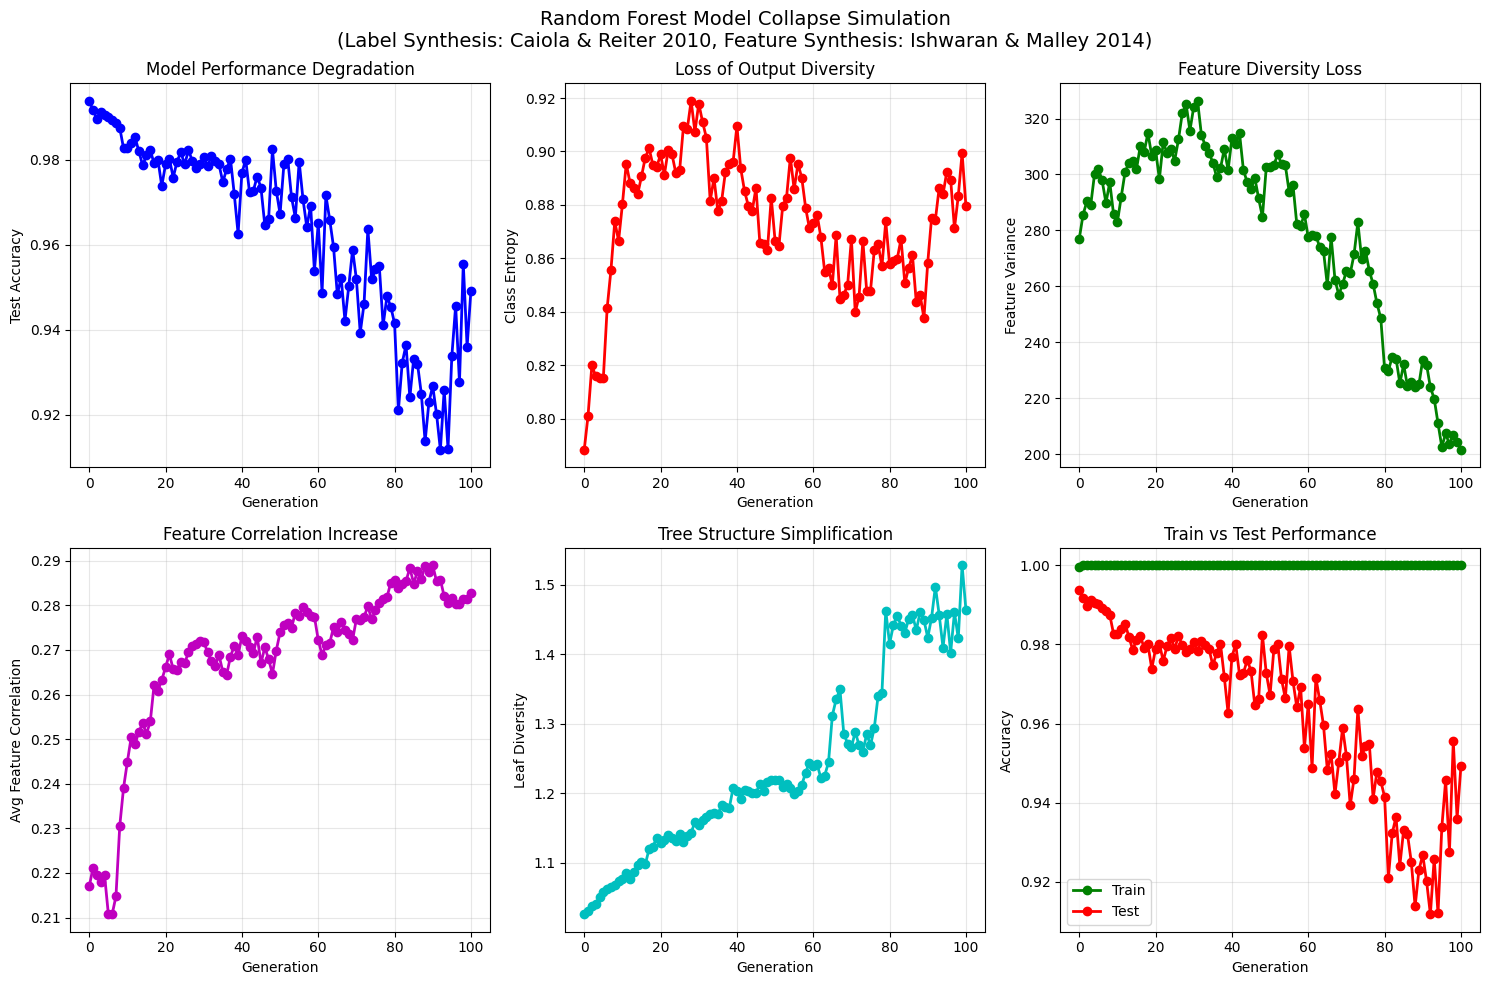

In [68]:
print_results(metrics)

In [56]:
confusion_matrix_text(metrics)

Confusion matrix 0:
[[1108   31]
 [   6 3402]]
Confusion matrix 1:
[[1104   35]
 [   4 3404]]
Confusion matrix 2:
[[1105   34]
 [   8 3400]]
Confusion matrix 3:
[[1106   33]
 [  10 3398]]
Confusion matrix 4:
[[1110   29]
 [  12 3396]]
Confusion matrix 5:
[[1106   33]
 [  12 3396]]
Confusion matrix 6:
[[1105   34]
 [  17 3391]]
Confusion matrix 7:
[[1106   33]
 [  12 3396]]
Confusion matrix 8:
[[1094   45]
 [  16 3392]]
Confusion matrix 9:
[[1090   49]
 [  19 3389]]
Confusion matrix 10:
[[1100   39]
 [  18 3390]]
Confusion matrix 11:
[[1106   33]
 [  19 3389]]
Confusion matrix 12:
[[1107   32]
 [  16 3392]]
Confusion matrix 13:
[[1098   41]
 [  12 3396]]
Confusion matrix 14:
[[1097   42]
 [  32 3376]]
Confusion matrix 15:
[[1107   32]
 [  22 3386]]
Confusion matrix 16:
[[1106   33]
 [  17 3391]]
Confusion matrix 17:
[[1101   38]
 [  14 3394]]
Confusion matrix 18:
[[1107   32]
 [  16 3392]]
Confusion matrix 19:
[[1102   37]
 [  24 3384]]
Confusion matrix 20:
[[1094   45]
 [  26 3382]]
Co

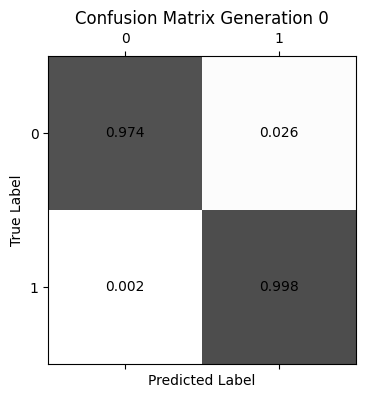

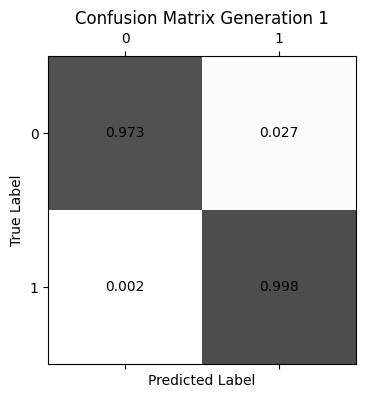

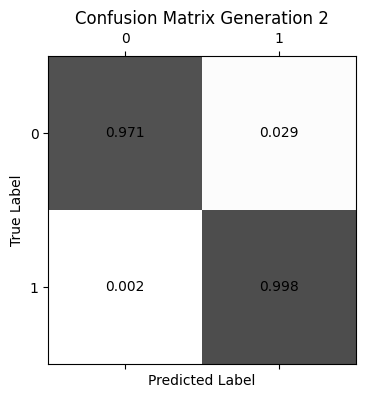

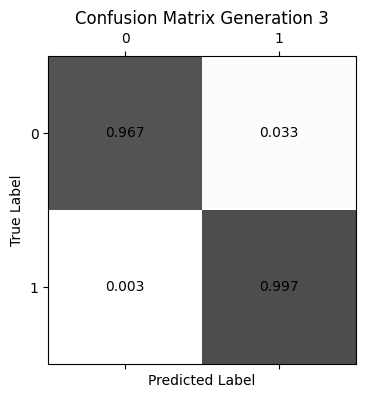

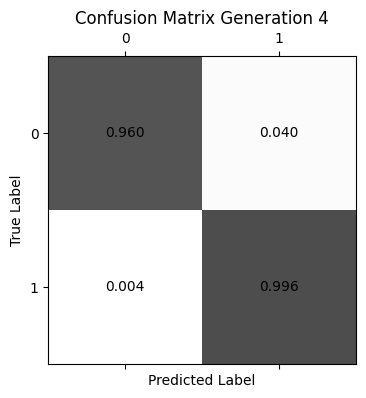

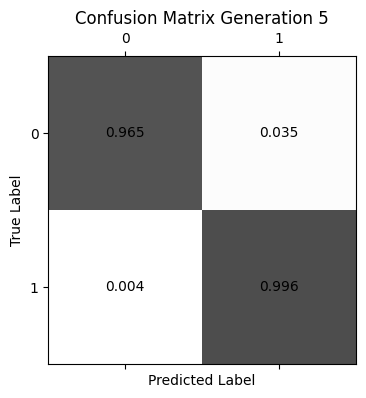

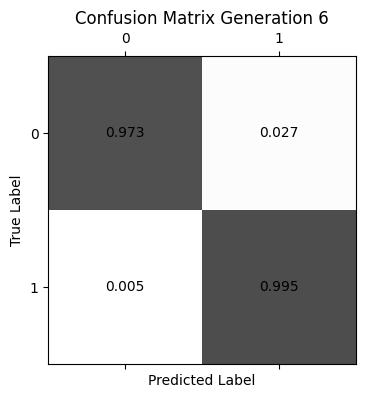

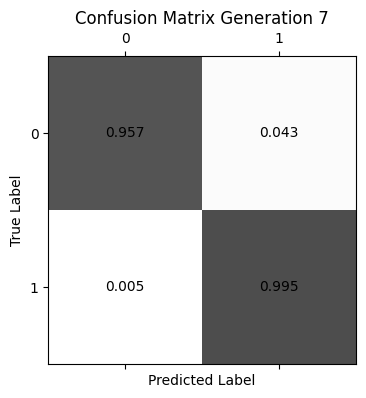

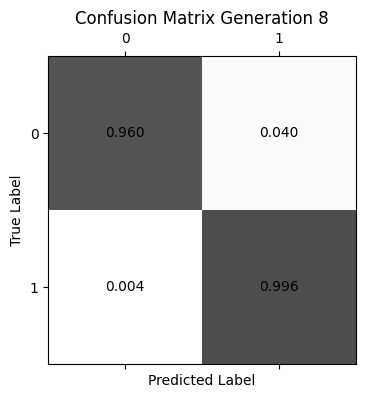

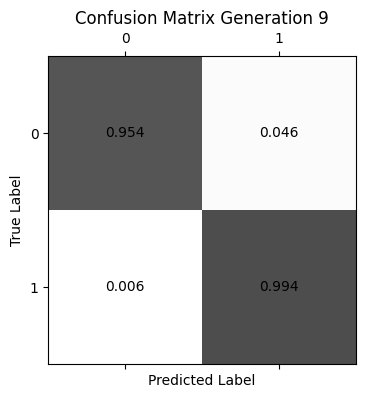

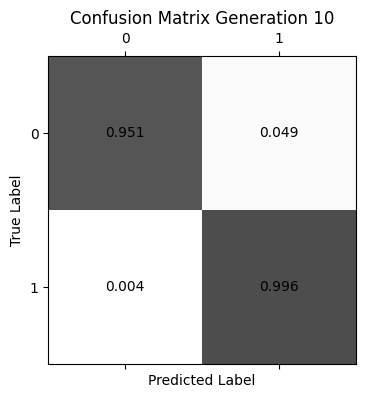

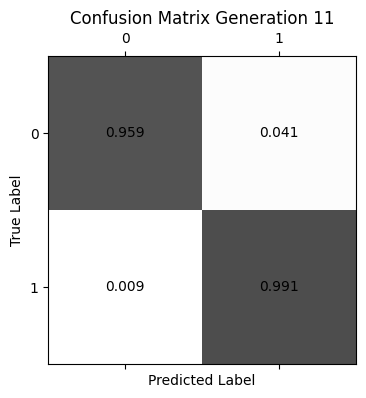

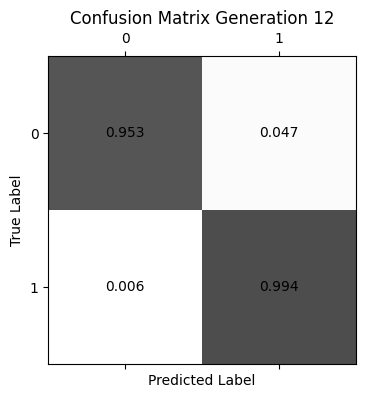

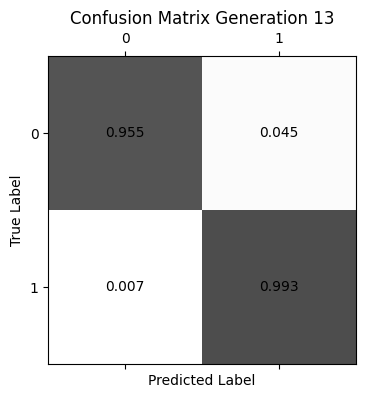

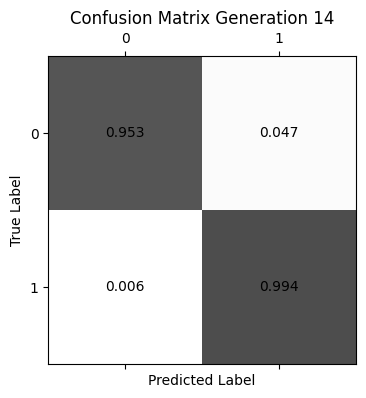

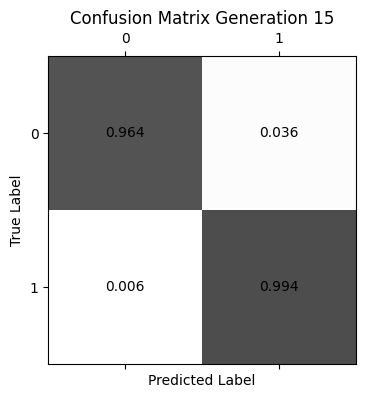

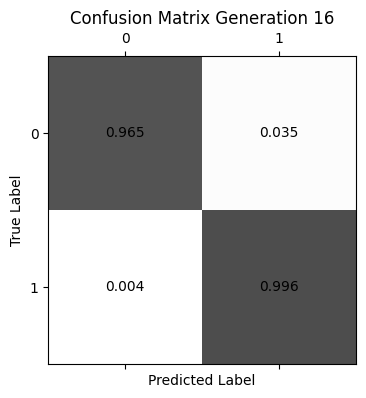

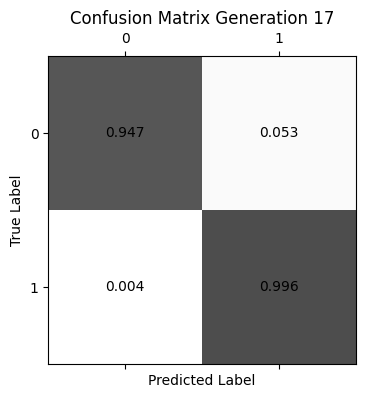

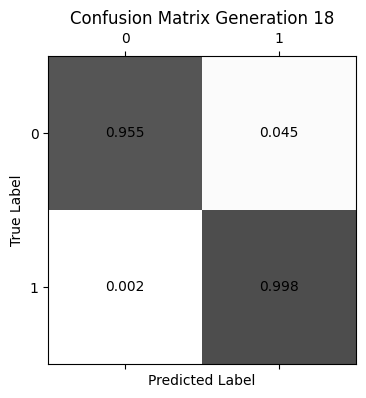

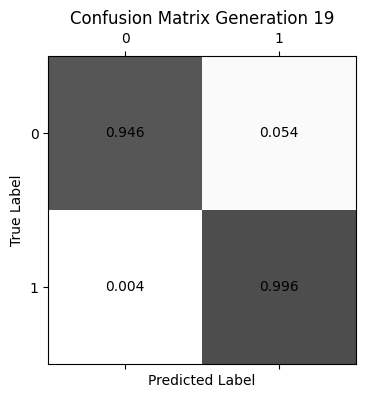

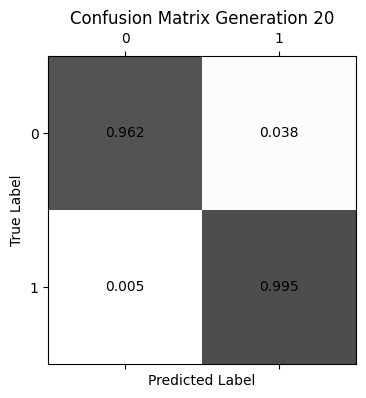

In [26]:
confusion_matrix_visual(metrics)